In [143]:
# Forked from excellent kernel : https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features
# From Kaggler : https://www.kaggle.com/jsaguiar
# Just removed a few min, max features. U can see the CV is not good. Dont believe in LB.

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('../input/application_train.csv', nrows= 40000)
    test_df = pd.read_csv('../input/application_test.csv', nrows= 10000)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    #df['AMT_INCOME_TOTAL'].replace(117000000.0,202500.0,inplace= True)
    df['AMT_REQ_CREDIT_BUREAU_IS']=df.AMT_REQ_CREDIT_BUREAU_DAY.map(lambda t:1 if t>0 else 0)
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    '''
    dropcolum=['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8','FLAG_DOCUMENT_9','FLAG_DOCUMENT_10', 
    'FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14','FLAG_DOCUMENT_15','FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20','FLAG_DOCUMENT_21']
    df= df.drop(dropcolum,axis=1)
    '''
    

    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    '''
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    '''
    num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var','std','sum','count','min','max','median','size'],
        'DAYS_CREDIT_ENDDATE': [ 'mean','var','std','sum','count','min','max','median','size'],
        'DAYS_CREDIT_UPDATE': ['mean','sum','var','std','count','min','max','median','size'],
        'CREDIT_DAY_OVERDUE': ['mean','sum','count','var','std','min','max','median','size'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean','sum','count','var','std','min','max','median','size'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum','count','min','max','var','std','median','size'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum','count','min','max','var','std','median','size'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean','sum','count','min','max','var','std','median','size'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum','count','min','max','median','var','std','size'],
        'AMT_ANNUITY': ['max', 'mean','sum','count','min','std','median','size','var'],
        'CNT_CREDIT_PROLONG': ['sum','count','min','max','median','size','mean','var','std'],
        'MONTHS_BALANCE_MIN': ['min','sum','count','mean','max','median','size','var','std'],
        'MONTHS_BALANCE_MAX': ['max','sum','count','min','mean','median','size','var','std'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum','count','min','max','median','size','var','std']
    }
    
    
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    
    num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'AMT_APPLICATION':[ 'max', 'mean','sum','count','size','var','std','median','min'],
        'AMT_CREDIT': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'APP_CREDIT_PERC': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'AMT_GOODS_PRICE': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'DAYS_DECISION': [ 'max', 'mean','sum','count','size','var','std','median','min'],
        'CNT_PAYMENT': [ 'max', 'mean','sum','count','size','var','std','median','min'],
    }
    
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size','count','min','sum','var','std','median'],
        'SK_DPD': ['max', 'mean', 'size','count','min','sum','var','std','median'],
        'SK_DPD_DEF': ['max', 'mean', 'size','count','min','sum','var','std','median']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': [ 'mean',  'var'],
        'PAYMENT_DIFF': [ 'mean', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum','min','count','size','median','std','var'],
        'DBD': ['max', 'mean', 'sum','min','count','size','median','std','var'],
        'PAYMENT_PERC':['max', 'mean', 'sum','min','count','size','median','std','var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum','min','count','size','median','std','var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum','min','count','size','median','std','var'],
        'AMT_PAYMENT': ['max', 'mean', 'sum','min','count','size','median','std','var'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum','min','count','size','median','std','var']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var'])
    cc_agg = cc.groupby('SK_ID_CURR').agg([ 'max', 'mean', 'sum', 'var','min','count','size','std','median'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df.TARGET!=9999]
    test_df = df[df.TARGET==9999]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    feats=aa
    len(feats)
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1, )
        

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 100, early_stopping_rounds= 200)

       
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)
    
    return df
if __name__ == "__main__":
    submission_file_name = "submission_kernel03.csv"
    #with timer("Full model run"):
    #   main()

In [125]:

pd.set_option('display.float_format', lambda x: '%.5f' % x) 

#df.describe()
#df['AMT_REQ_CREDIT_BUREAU_IS']=df.AMT_REQ_CREDIT_BUREAU_DAY.map(lambda t:1 if t>0 else 0)
#df['AMT_REQ_CREDIT_BUREAU_IS'].describe()

df.shape
def source_2(t):
    if t<0.0001:
        return np.NaN
    else:
        return t
df['TARGET'].replace( np.nan,9999, inplace= True)
df['EXT_SOURCE_2']=df.EXT_SOURCE_2.map(lambda t:source_2(t))
df=df[df.AMT_ANNUITY<df.AMT_INCOME_TOTAL].iloc[:,1:]
#df.head()
#df[df.index==12840]

#df = impute.fit_transform(df)
#df=pd.DataFrame(df)
#df.columns=columns

In [320]:
df.head()
df.shape
df.columns

Index(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       ...
       'TARGET', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE',
       'WEEKDAY_APPR_PROCESS_START', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_MODE',
       'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'],
      dtype='object', length=122)

In [365]:
#df[df.TARGET==9999].head()
#df.TARGET.drop_duplicates()
#df[df.TARGET.isnull()==False].shape
#df.head().iloc[:,68:]
#df['FLOORSMIN_AVG'].describe()
#for feature in df.columns:
#    print('--------')
#    print(feature)
#    print(df[feature].max())

In [540]:
df[df.TARGET==9999].shape
#df.shape
#df[df.TARGET.isnull()==False].shape
#df.TARGET.drop_duplicates()
df.TARGET.drop_duplicates()
df.head()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_COUNT,CC_NAME_CONTRACT_STATUS_nan_SIZE,CC_NAME_CONTRACT_STATUS_nan_STD,CC_NAME_CONTRACT_STATUS_nan_MEDIAN,CC_COUNT
0,24700.50000,406597.50000,351000.00000,202500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,22.00000,22.00000,0.00000,0.00000,22.00000
1,35698.50000,1293502.50000,1129500.00000,270000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,22.00000,22.00000,0.00000,0.00000,22.00000
2,6750.00000,135000.00000,135000.00000,67500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,22.00000,22.00000,0.00000,0.00000,22.00000
3,29686.50000,312682.50000,297000.00000,135000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,6.00000,0.00000,0.00000,6.00000
4,21865.50000,513000.00000,513000.00000,121500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,22.00000,22.00000,0.00000,0.00000,22.00000


In [141]:
#df[df.TARGET.isnull()==True].shape

#for col in df.columns:
#    print(df[col].mean())
#    print(df[col].std())

df.head()
#outlier=df['AMT_ANNUITY'].mean()+df['AMT_ANNUITY'].std()*3
df[df.AMT_ANNUITY>71624].shape



(3481, 1466)

In [144]:

num_rows = None
df = application_train_test(num_rows)
#df = pd.read_csv('../input/application_train.csv', nrows= 50000)
#test_df = pd.read_csv('../input/application_test.csv', nrows= 10000)
#print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
#df = df.append(test_df).reset_index()
#for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
#        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
#df, cat_cols = one_hot_encoder(df, nan_as_category)

with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    #df = df.loc[:,['SK_ID_CURR','TARGET']].join(bureau, how='left', on='SK_ID_CURR')
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()

with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()

with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()

with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()

with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()


Train samples: 40000, test samples: 10000
Bureau df shape: (305811, 413)
Process bureau and bureau_balance - done in 55s


KeyboardInterrupt: 

In [142]:
#len(aa)
df.shape
df.head()

,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_COUNT,CC_NAME_CONTRACT_STATUS_nan_SIZE,CC_NAME_CONTRACT_STATUS_nan_STD,CC_NAME_CONTRACT_STATUS_nan_MEDIAN,CC_COUNT
0,0,24700.50000,406597.50000,351000.00000,202500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,1,35698.50000,1293502.50000,1129500.00000,270000.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,6750.00000,135000.00000,135000.00000,67500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,3,29686.50000,312682.50000,297000.00000,135000.00000,nan,nan,nan,nan,nan,...,0.00000,0.00000,0.00000,0.00000,0.00000,6.00000,6.00000,0.00000,0.00000,6.00000
4,4,21865.50000,513000.00000,513000.00000,121500.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [145]:
num_rows=None
train = pd.read_csv('../input/application_train.csv', nrows= num_rows)

test_df = pd.read_csv('../input/application_test.csv', nrows= num_rows)
bureau = pd.read_csv('../input/bureau.csv', nrows = num_rows)
bb = pd.read_csv('../input/bureau_balance.csv', nrows = num_rows)
prev = pd.read_csv('../input/previous_application.csv', nrows = num_rows)
pos = pd.read_csv('../input/POS_CASH_balance.csv', nrows = num_rows)
ins = pd.read_csv('../input/installments_payments.csv', nrows = num_rows)
cc = pd.read_csv('../input/credit_card_balance.csv', nrows = num_rows)


In [146]:
train.head()
indexs=['','','','','','','','','','','','','','','','','','']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,...,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,...,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [363]:
#aa
df=pd.concat([train,test_df])
df.loc[:,['TARGET','FLAG_EMP_PHONE','SK_ID_CURR']].groupby(['FLAG_EMP_PHONE','TARGET']).count()
#df.loc[:,['AMT_ANNUITY','SK_ID_CURR']].groupby(['AMT_ANNUITY']).count()
#df['FLAG_CONT_MOBILE'].describe()
#df[df.AMT_INCOME_TOTAL>4000000]
#df[df.AMT_CREDIT>3000000]
#indexs=['12840']
#df[df.index==12840]
#df[df.CNT_CHILDREN>5].loc[:,['TARGET','SK_ID_CURR']].groupby(['TARGET']).count()
#train[train.CNT_CHILDREN>5].loc[:,['TARGET','SK_ID_CURR']].groupby(['TARGET']).count()
#df['AMT_REQ_CREDIT_BUREAU_QRT'].drop_duplicates()
#df[df.AMT_REQ_CREDIT_BUREAU_QRT==261]

SK_ID_CURR
FLAG_EMP_PHONE TARGET             
0              0.00000       52395
               1.00000        2991
1              0.00000      230291
               1.00000       21834

In [361]:
df.head().iloc[:,60:]
#df[df.DEF_30_CNT_SOCIAL_CIRCLE>25]
#for col in aa:
#    if col=='NEW_EXT_SOURCES_MEAN':
#        print(111)

,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,...,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,0,1,1,N,Y,1,0,0.08330,0.08330,0.08330,...,1.00000,0.01490,"Stone, brick",WEDNESDAY,0.97220,0.97220,0.97220,0.61920,0.62430,0.63410
1,0,1,1,N,N,1,0,0.29170,0.29170,0.29170,...,0.00000,0.07140,Block,MONDAY,0.98510,0.98510,0.98510,0.79600,0.79870,0.80400
2,0,1,1,Y,Y,1,1,nan,nan,nan,...,0.00000,nan,NaN,MONDAY,nan,nan,nan,nan,nan,nan
3,0,1,1,N,Y,0,0,nan,nan,nan,...,0.00000,nan,NaN,WEDNESDAY,nan,nan,nan,nan,nan,nan
4,0,1,1,N,Y,0,0,nan,nan,nan,...,0.00000,nan,NaN,THURSDAY,nan,nan,nan,nan,nan,nan


In [364]:
df.head()
aa

['NEW_EXT_SOURCES_MEAN',
 'NEW_CREDIT_TO_ANNUITY_RATIO',
 'NEW_CREDIT_TO_GOODS_RATIO',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'EXT_SOURCE_3',
 'NEW_EMPLOY_TO_BIRTH_RATIO',
 'NEW_ANNUITY_TO_INCOME_RATIO',
 'ACTIVE_DAYS_CREDIT_MAX',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_2',
 'DAYS_ID_PUBLISH',
 'EXT_SOURCE_1',
 'CODE_GENDER',
 'INSTAL_AMT_PAYMENT_MIN',
 'APPROVED_CNT_PAYMENT_VAR',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'DAYS_REGISTRATION',
 'INSTAL_DPD_MEAN',
 'INSTAL_AMT_INSTALMENT_MIN',
 'INSTAL_AMT_PAYMENT_MEDIAN',
 'REGION_POPULATION_RELATIVE',
 'NEW_SOURCES_PROD',
 'NEW_CREDIT_TO_INCOME_RATIO',
 'PREV_CNT_PAYMENT_VAR',
 'NAME_EDUCATION_TYPE_Higher education',
 'NEW_CAR_TO_EMPLOY_RATIO',
 'INSTAL_DBD_SUM',
 'INSTAL_DPD_STD',
 'APPROVED_CNT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_MEDIAN',
 'PREV_NAME_YIELD_GROUP_high_MEAN',
 'NAME_FAMILY_STATUS_Married',
 'PREV_NAME_CONTRACT_STATUS_Refused_MEAN',
 'AMT_CREDIT',
 'INSTAL_PAYMENT_DIFF_MAX',
 'NEW_SCORES_STD',
 'CLOSED_AMT_CREDIT_SUM_MEDIAN',
 'INSTAL

In [236]:
df[(df.CNT_CHILDREN>6)&(df.TARGET==1)].shape
df[(df.CNT_CHILDREN>6)&(df.TARGET==0)].shape
#df.loc[:,['','CNT_CHILDREN','TARGET']]

(18, 122)

In [446]:
#bureau.head()
import numpy as np
np.set_printoptions(suppress=True)

df.shape
df['AMT_INCOME_TOTAL'].replace(117000000.0, 202500.0, inplace= True)
#aa.append('AMT_REQ_CREDIT_BUREAU_IS')
#aa.remove('AMT_REQ_CREDIT_BUREAU_IS')
len(aa)
df[df.index==12840]
#len(aa)
df[df.index==12840]['AMT_INCOME_TOTAL']=[202500.0]
df[df.index==12840]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,index,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,...,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_COUNT,CC_NAME_CONTRACT_STATUS_nan_SIZE,CC_NAME_CONTRACT_STATUS_nan_STD,CC_NAME_CONTRACT_STATUS_nan_MEDIAN,CC_COUNT,AMT_REQ_CREDIT_BUREAU_IS
12840,12840,26194.50000,562491.00000,454500.00000,nan,0.00000,0.00000,0.00000,0.00000,0.00000,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00000


Starting LightGBM. Train shape: (39994, 1463), test shape: (9987, 1463)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.833353	valid_1's auc: 0.766458
[200]	training's auc: 0.872374	valid_1's auc: 0.778659
[300]	training's auc: 0.895232	valid_1's auc: 0.780538
[400]	training's auc: 0.911234	valid_1's auc: 0.780946
[500]	training's auc: 0.924649	valid_1's auc: 0.780574
[600]	training's auc: 0.936251	valid_1's auc: 0.780603
Early stopping, best iteration is:
[461]	training's auc: 0.919983	valid_1's auc: 0.781049
Fold  1 AUC : 0.781049
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.837863	valid_1's auc: 0.7604
[200]	training's auc: 0.874585	valid_1's auc: 0.766725
[300]	training's auc: 0.897392	valid_1's auc: 0.76777
[400]	training's auc: 0.914163	valid_1's auc: 0.767259
[500]	training's auc: 0.927656	valid_1's auc: 0.767149
Early stopping, best iteration is:
[328]	training's auc: 0.90244	valid_1's auc: 0.76874

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:378: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 644s


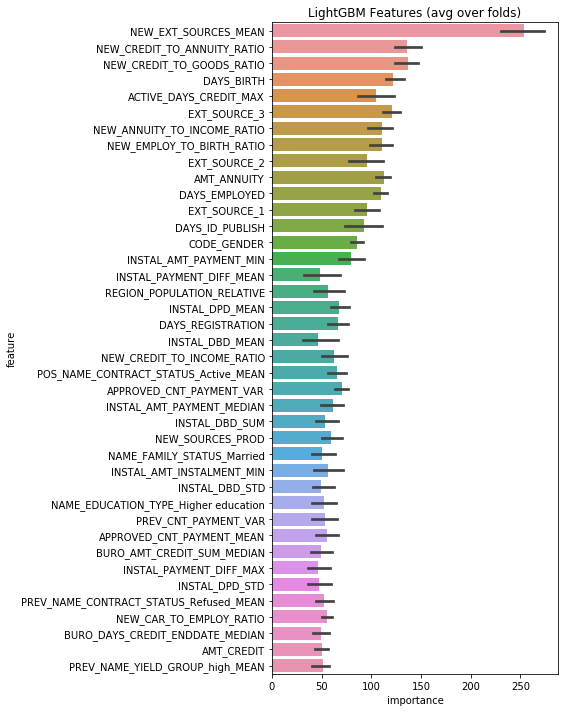

In [128]:
with timer("Run LightGBM with kfold"):
    feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= False)

In [119]:
len(aa)

863

In [313]:
#aa=feat_importance[(feat_importance.fold==5)&(feat_importance.importance>0)].sort_values(['importance'],ascending=False)
#feat_importance[feat_importance.feature=='NAME_CONTRACT_TYPE_Cash loans']
len(aa)
#for col in aa:
#    print(col)


853

In [113]:
feat_importance[(feat_importance.fold==5)&(feat_importance.importance>0)].sort_values(['importance'],ascending=False)
#feat_importance[feat_importance.feature=='NAME_CONTRACT_TYPE_Cash loans']
df=feat_importance[(feat_importance.importance>0)&(feat_importance.fold==1)]

for i in range(4):
    i+=2

    df=df.merge(feat_importance[(feat_importance.importance>0)&(feat_importance.fold==i)],on=['feature'])
df.head()
feat_importance=feat_importance[feat_importance.importance>0]
aa=feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).reset_index().feature.tolist()
len(aa)
bb=feat_importance.feature.tolist()


(863, 1)

In [159]:
'''
df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
'''
feats=['NEW_CREDIT_TO_ANNUITY_RATIO','NEW_CREDIT_TO_GOODS_RATIO','NEW_DOC_IND_KURT',\
      'NEW_LIVE_IND_SUM','NEW_INC_PER_CHLD','NEW_INC_BY_ORG','NEW_EMPLOY_TO_BIRTH_RATIO',\
      'NEW_ANNUITY_TO_INCOME_RATIO','NEW_SOURCES_PROD','NEW_EXT_SOURCES_MEAN','NEW_SCORES_STD',\
      'NEW_CAR_TO_BIRTH_RATIO','NEW_CAR_TO_EMPLOY_RATIO','NEW_PHONE_TO_BIRTH_RATIO',\
      'NEW_CREDIT_TO_INCOME_RATIO','TARGET','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
feats=['AMT_PAYMENT','TARGET']
#feats=['NEW_CREDIT_TO_ANNUITY_RATIO','TARGET']
df.loc[:,feats].corr()['TARGET'].sort_values()


TARGET         1.0
AMT_PAYMENT    NaN
Name: TARGET, dtype: float64

0          1.000000
1          0.893815
2          0.824511
3          0.955840
4          0.835282
5          0.924910
6               NaN
7               NaN
8               NaN
9               NaN
10         0.804160
11         0.858369
12         0.851679
13         0.934256
14         0.974240
15         1.055380
16         0.987471
17         1.000000
18         1.000000
19         0.909918
20         0.915416
21         0.896459
22              NaN
23         0.884423
24              NaN
25         0.948661
26         1.000000
27         0.923222
28         1.137174
29              NaN
             ...   
1670184    0.893815
1670185    0.847458
1670186         NaN
1670187         NaN
1670188    1.000000
1670189    0.834725
1670190         NaN
1670191    1.000000
1670192    0.000000
1670193         NaN
1670194    0.836400
1670195    1.111111
1670196    1.000000
1670197    1.000000
1670198    1.111305
1670199    0.926561
1670200    0.883392
1670201    0.839707
1670202    0.930956


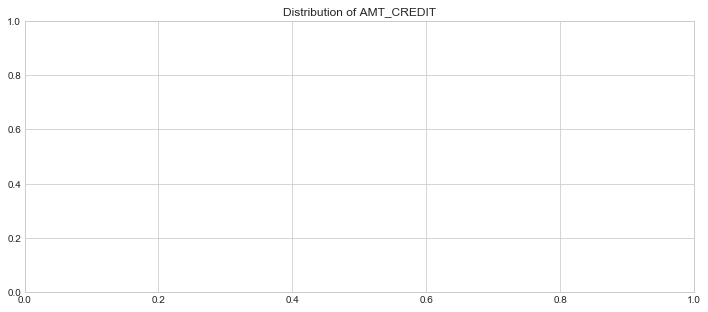

In [180]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
#ax = sns.distplot(prev["APP_CREDIT_PERC"].dropna())
#prev['AMT_ANNUITY'].head()
#var = ['AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_EMPLOYED', 'DAYS_REGISTRATION','DAYS_BIRTH','DAYS_ID_PUBLISH']
#var=['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','NEW_EXT_SOURCES_MEAN','NEW_SOURCES_PROD']
#feats=['NEW_CREDIT_TO_GOODS_RATIO']
#plot_distribution_comp(feats,nrow=5)
#prev.head()

In [49]:
def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], label="TARGET = 1")
        sns.kdeplot(t0[feature], label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();

In [2]:
df=main()

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 38s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 37s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 22)
Process installments payments - done in 50s
Credit card balance df shape: (103536, 117)
Process credit card balance - done in 32s


In [5]:
#df.loc[:,['DAYS_BIRTH','EXT_SOURCE_3']]
#corr_matrix = train.corr().abs()
#corr_matrix.head()

feats = [f for f in df.columns if f not in ['SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
correlations= df[feats].corr()['TARGET'].sort_values()
#df[feats].head()

In [6]:
correlations

NEW_EXT_SOURCES_MEAN                               -0.222054
NEW_SOURCES_PROD                                   -0.188556
EXT_SOURCE_3                                       -0.178926
EXT_SOURCE_2                                       -0.160471
EXT_SOURCE_1                                       -0.155317
BURO_MONTHS_BALANCE_SIZE_MEAN                      -0.080193
BURO_CREDIT_ACTIVE_Closed_MEAN                     -0.079369
PREV_CODE_REJECT_REASON_XAP_MEAN                   -0.073938
NEW_EMPLOY_TO_BIRTH_RATIO                          -0.067952
ACTIVE_MONTHS_BALANCE_SIZE_MEAN                    -0.065154
PREV_NAME_CONTRACT_STATUS_Approved_MEAN            -0.063526
CC_COUNT                                           -0.060663
CC_NAME_CONTRACT_STATUS_Active_SUM                 -0.059569
CC_MONTHS_BALANCE_VAR                              -0.058988
CLOSED_MONTHS_BALANCE_SIZE_MEAN                    -0.058354
NAME_EDUCATION_TYPE_Higher education               -0.056593
BURO_STATUS_C_MEAN_MEAN 

In [4]:
df.loc[:,['AMT_ANNUITY','AMT_CREDIT','AMT_GOODS_PRICE','AMT_INCOME_TOTAL','TARGET']].corr()['TARGET'].sort_values()

AMT_GOODS_PRICE    -0.039647
AMT_CREDIT         -0.030371
AMT_ANNUITY        -0.012818
AMT_INCOME_TOTAL   -0.003982
TARGET              1.000000
Name: TARGET, dtype: float64